# **Kaggle Challenge - Porto Seguro Car Insurance**


**Description:** Porto Seguro is one of Brazil biggest Auto Insurance companies. In order to better assess risks and socts associated to their services, they have to make the best possible predictions of car crash probabilities for their customers.

**Index:**

1. Business problem
2. Objectives and KPIs
3. Basic setup
4. Data collection and summary
5. Introductory data cleaning
6. Exploratory data analysis
7. Feature and Target analysis
8. Data Modelling
9. Machine Learning application
10. Model metric assesment
11. Submitting model to a production environment

## 1. Business Problem

Insurance companies, in general, have their business models based around providing cost aid for their customers when they have specific incidents, such as auto theft, fires or health related issues. According to strategic adviser Sean Ross, in their article to online portal Insvestopedia, 

*Insurance companies base their business models around assuming and diversifying risk. The essential insurance model involves pooling risk from individual payers and redistributing it across a larger portfolio. Most insurance companies generate revenue in two ways: Charging premiums in exchange for insurance coverage[...]* (Ross, Sean 2021)

The amount that clients are not claiming can be added by financial investing, which, according to the same source, is performed by most insurance companies.

This set of informations lead us to the final conclusion about this business model:

Revenue (R) = Profit (P) + Costs (C)

Where, for Insurance Companies:

#### Main Revenue components:

* Client Premiums
* Investments

Premium prices are determined by a combination of the market prices and the individual client risk, based on a *Risk Score*. The score is based on the foreseable probability of a claim being filled by the client, which means that the lowest this score is, the cheapest the insurance premium will be.

#### Main Cost components:

* Client claims
* Investment losses

With these informations we can safely conclude for a revenue model with the following equation:

Total Revenue = Total of Premium + Investment Gains - (Total of aprooved claims + Administrative and Investiment losses)

So if we wished to asses the Premium for an individual client, that could safely be approximated by something like:

**Premium = Lowest Premium Price + (Risk Associated Price Increase * Risk Score)**

Our objetive in the project is to predict wether a client is likely to fill a claim, based on a list of factors. Thsi is, we will be actually scoring the client and providing this valuable information to orur clietn company.

## 2. Objectives and KPIs

Last, we should have in mind the possible factors that influence a client`s Risk Score. 

According to Porto Seguro`s own portal, some factors should be observed:

* The client`s insurance claim record
* The client`s experience as a licensed driver
* The region (safety consitions, mostly)
* The vehicle brand
* The vehicle`s year of fabrication
* Vehicle safety features (such as alarms)
* If the vehicle will be parked indoors (in a garage)

Source: https://www.meuportoseguro.com.br/meu-carro/seguro-auto/saiba-o-que-influencia-valor-seguro-auto/


Insurance providers typically use the client`s credit scores for assessing claim risk, but this has been controversial and some locations, such as the American states of California and Massachusets. According to latest reviews, this parctice is still allowed in Brazil and widely used, so we will be allowing for in this project, if needed.

Our target will be to better predict wether the client will file a claim. 

**KPI:** Our model`s rate of right predictions on a test dataset of clients provided by Porto Seguro. 


## 3. Basic setup

Importing our libraries:

In [2]:
## data analysis and manipulation:

import pandas as pd
import numpy as np

## graphic analysis

import seaborn as sns
import matplotlib.pyplot as plt 

## machine learning modelling

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

## export files

from google.colab import files

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## 4. Data collection and summary

We will be analyzing our model data trainning data, hence the name *train.csv*. Our data has been provided by:

https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview

In [3]:
data = pd.read_csv("train.csv")

Analyzing our data:

In [4]:
data.shape

(313079, 59)

In [5]:
data.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10.0,1.0,10.0,1.0,5.0,9.0,1.0,5.0,8.0,0.0,1.0,1.0,0.0,0.0,1.0
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9.0,5.0,8.0,1.0,7.0,3.0,1.0,1.0,9.0,0.0,1.0,1.0,0.0,1.0,0.0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9.0,1.0,8.0,2.0,7.0,4.0,2.0,7.0,7.0,0.0,1.0,1.0,0.0,1.0,0.0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7.0,1.0,8.0,4.0,2.0,2.0,2.0,4.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6.0,3.0,10.0,2.0,12.0,3.0,1.0,1.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0


Our data has

* 113505 observations
* 58 features (categorical and numeric)
* 1 target (if said client filed a claim is 1, else is 0)

According to Porto Seguro, each line is a policy holder (client)

We can also note that the feature meanings have been hidden.

## 5. Introductory data cleaning

For this analysis, we will separate our target from features:

In [6]:
target = data.target
features = data.drop(["target", "id"], axis = 1)

Analyzing target:

In [7]:
target.describe()

count    313079.000000
mean          0.036486
std           0.187496
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: target, dtype: float64

In [8]:
target.isna().sum()

0

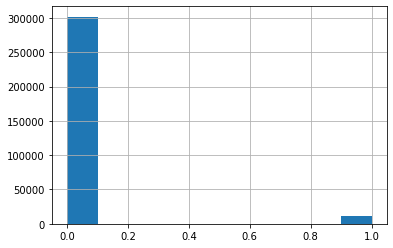

In [9]:
target.hist()

In [10]:
target.value_counts(normalize=True)

0    0.963514
1    0.036486
Name: target, dtype: float64

Target perceptions:

* Target has been predicted for every row (no row with NA or a value different than 0 or 1)

* Around 96% of our policy holders did not file a claim

**The expected probability of a policy holder filing a claim is 3.67%, so our baseline for the model is 96.33%, which is the chance of being right by just guessing the policy holder will not claim, it has to be better than that.** 

This also shows that the data is unbalanced

Analyzing features:

In [11]:
features.describe()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,313079.000000,313079.000000,313079.000000,313079.000000,313079.000000,313079.000000,313079.000000,313079.000000,313079.000000,313079.000000,313079.000000,313079.000000,313079.000000,313079.000000,313079.000000,313079.000000,313079.000000,313079.000000,313079.000000,313079.000000,313079.000000,313079.000000,313079.000000,313079.000000,313079.000000,313079.000000,313079.000000,313079.000000,313079.000000,313079.000000,313079.000000,313079.000000,313079.000000,313079.000000,313079.000000,313079.000000,313079.000000,313079.000000,313079.000000,313079.000000,313079.000000,313079.000000,313078.000000,313078.000000,313078.000000,313078.000000,313078.000000,313078.000000,313078.000000,313078.000000,313078.000000,313078.000000,313078.000000,313078.000000,313078.000000,313078.000000,313078.000000
mean,1.899246,1.358235,4.424650,0.416167,0.405166,0.393872,0.256105,0.164224,0.185800,0.000374,0.001696,0.009541,0.000987,0.012597,7.302850,0.660980,0.120883,0.153211,0.611291,0.440317,0.551099,8.297698,0.830193,-0.505764,0.722176,-0.158225,6.562912,0.910821,0.832049,1.328176,0.992168,62.177910,2.343472,0.379913,0.813004,0.276637,3.065765,0.449642,0.449401,0.449918,2.369836,1.886527,7.687503,3.006503,9.226416,2.339855,8.431033,5.443551,1.443707,2.872632,7.535087,0.122660,0.628383,0.554686,0.287654,0.348277,0.153585
std,1.984332,0.663892,2.701732,0.493182,1.350167,0.488608,0.436481,0.370479,0.388946,0.019328,0.041148,0.097210,0.031401,0.128558,3.546819,0.473377,0.325992,0.360191,0.288015,0.404271,0.794647,2.507497,0.375481,0.788149,2.147659,0.844511,5.503272,0.345361,0.373824,0.978693,0.091214,33.017203,0.833685,0.058356,0.223857,0.356436,0.732928,0.287088,0.287001,0.287165,1.117514,1.135183,1.335817,1.416160,1.458958,1.247948,2.905457,2.332005,1.205050,1.693747,2.744958,0.328047,0.483237,0.497001,0.452669,0.476425,0.360551
min,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,1.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.400000,0.200000,0.525000,7.000000,1.000000,-1.000000,0.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,32.000000,2.000000,0.316228,0.670924,0.333916,2.828427,0.200000,0.200000,0.200000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000,0.000000,0.000000,0.700000,0.300000,0.721110,7.000000,1.000000,-1.000000,0.000000,0.000000,7.000000,1.000000,1.000000,2.000000,1.000000,65.000000,3.000000,0.374166,0.766000,0.368782,3.316625,0.500000,0.400000,0.500000,2.000000,2.000000,8.000000

Some categorical features have a minimum value of -1. According to our documentation, this is means that the feature was missing for that observation.

In [22]:
data_not_na = data
data_not_na = data.replace(-1, None)

In [23]:
data_not_na.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10.0,1.0,10.0,1.0,5.0,9.0,1.0,5.0,8.0,0.0,1.0,1.0,0.0,0.0,1.0
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9.0,5.0,8.0,1.0,7.0,3.0,1.0,1.0,9.0,0.0,1.0,1.0,0.0,1.0,0.0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,0.766078,7,1,-1,0,1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9.0,1.0,8.0,2.0,7.0,4.0,2.0,7.0,7.0,0.0,1.0,1.0,0.0,1.0,0.0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7.0,1.0,8.0,4.0,2.0,2.0,2.0,4.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,0,0,1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6.0,3.0,10.0,2.0,12.0,3.0,1.0,1.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0


In [24]:
data_not_na.isna().sum()

id                0
target            0
ps_ind_01         0
ps_ind_02_cat     0
ps_ind_03         0
ps_ind_04_cat     0
ps_ind_05_cat     0
ps_ind_06_bin     0
ps_ind_07_bin     0
ps_ind_08_bin     0
ps_ind_09_bin     0
ps_ind_10_bin     0
ps_ind_11_bin     0
ps_ind_12_bin     0
ps_ind_13_bin     0
ps_ind_14         0
ps_ind_15         0
ps_ind_16_bin     0
ps_ind_17_bin     0
ps_ind_18_bin     0
ps_reg_01         0
ps_reg_02         0
ps_reg_03         0
ps_car_01_cat     0
ps_car_02_cat     0
ps_car_03_cat     0
ps_car_04_cat     0
ps_car_05_cat     0
ps_car_06_cat     0
ps_car_07_cat     0
ps_car_08_cat     0
ps_car_09_cat     0
ps_car_10_cat     0
ps_car_11_cat     0
ps_car_11         0
ps_car_12         0
ps_car_13         0
ps_car_14         0
ps_car_15         0
ps_calc_01        0
ps_calc_02        0
ps_calc_03        0
ps_calc_04        0
ps_calc_05        0
ps_calc_06        1
ps_calc_07        1
ps_calc_08        1
ps_calc_09        1
ps_calc_10        1
ps_calc_11        1


The maximum  numbers of obsrevations with mising featuers is 11

In [25]:
data_not_na.dropna().shape

(313078, 59)

There is actually only one observation with 11 missing features. We will keep this dataset without it and use it later

In [26]:
data_not_na = data_not_na.dropna()
data_not_na.shape

(313078, 59)

In [27]:
# we also need to dummify categorical columns

data_cat = data_not_na.filter(regex= "cat")
dummies = pd.get_dummies(data_cat.astype(str))
data_not_na.drop(data_cat.columns, axis=1, inplace=True)
data_not_na = pd.concat([dummies, data_not_na], axis = 1)

In [28]:
data_not_na.shape

(313078, 221)

## 6. Dataset analysis

Transforming our target into a balanced version

In [35]:
data_not_na_unbalanced = data_not_na

over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(data_not_na.drop(["target", "id"], axis=1), 
                                                    data_not_na.target)

data_not_na_cols = (data_not_na.drop(['target', 'id'], axis = 1)).columns
data_not_na = pd.DataFrame(X_res, columns = data_not_na_cols)
data_not_na['target'] = y_res

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


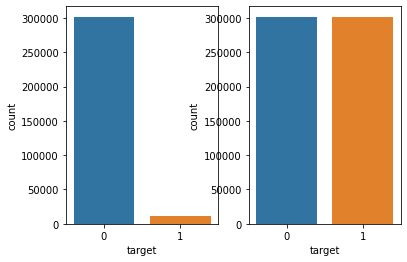

In [57]:
fig, ax =plt.subplots(1,2)
sns.countplot(data_not_na_unbalanced.target, ax=ax[0])
sns.countplot(data_not_na.target, ax=ax[1])
fig.show()

In [37]:
data_not_na.shape

(603310, 220)

Exploring how variables correlate with each other?

In [36]:
corr = data_not_na.corr()
corr

,ps_ind_02_cat_1,ps_ind_02_cat_2,ps_ind_02_cat_3,ps_ind_02_cat_4,ps_ind_04_cat_0,ps_ind_04_cat_1,ps_ind_05_cat_0,ps_ind_05_cat_1,ps_ind_05_cat_2,ps_ind_05_cat_3,ps_ind_05_cat_4,ps_ind_05_cat_5,ps_ind_05_cat_6,ps_car_01_cat_0,ps_car_01_cat_1,ps_car_01_cat_10,ps_car_01_cat_11,ps_car_01_cat_2,ps_car_01_cat_3,ps_car_01_cat_4,ps_car_01_cat_5,ps_car_01_cat_6,ps_car_01_cat_7,ps_car_01_cat_8,ps_car_01_cat_9,ps_car_02_cat_0,ps_car_02_cat_1,ps_car_03_cat_-1,ps_car_03_cat_0,ps_car_03_cat_1,ps_car_04_cat_0,ps_car_04_cat_1,ps_car_04_cat_2,ps_car_04_cat_3,ps_car_04_cat_4,ps_car_04_cat_5,ps_car_04_cat_6,ps_car_04_cat_7,ps_car_04_cat_8,ps_car_04_cat_9,...,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,target
ps_ind_02_cat_1,1.000000,-0.827247,-0.361403,-0.235924,0.101911,-0.101911,-0.026698,0.015503,0.028161,0.017565,0.008786,0.018225,-0.003243,-0.006467,-0.005611,-0.009690,-0.007395,-0.025382,-0.032250,0.011872,0.016577,-0.001249,0.011490,-0.005236,0.015107,0.070979,-0.070979,-0.001908,0.007094,-0.007085,-0.087816,-0.011956,0.043091,0.001611,-0.001130,-0.002320,0.016832,-0.000687,0.061212,0.078928,...,0.006616,-0.095724,-0.002202,-0.006974,0.004555,0.005019,0.002069,0.021247,-0.032423,0.037423,0.011150,-0.073142,-0.097176,-0.062243,-0.041144,0.152440,0.107797,0.100414,-0.005412,0.009628,-0.000019,-0.003584,0.001109,-0.000230,0.005230,-0.002481,0.001032,0.001754,0.007532,0.005278,0.000838,0.009809,0.005191,-0.005296,-0.001528,-0.002095,0.004518,-0.007326,0.000484,-0.019954
ps_ind_02_cat_2,-0.827247,1.000000,-0.117314,-0.076582,-0.026357,0.026357,0.034302,-0.017496,-0.032369,-0.021119,-0.012919,-0.017892,0.000077,0.005803,0.006884,0.017228,-0.000508,0.027834,0.031384,-0.008663,-0.014110,-0.007414,-0.006758,0.012107,-0.015591,-0.075905,0.075905,0.000664,0.000076,-0.000079,0.084404,0.008860,-0.031897,-0.000773,0.003214,-0.002667,-0.018989,0.003085,-0.060997,-0.079370,...,-0.037401,0.063174,0.000165,0.006133,-0.006810,-0.008614,-0.005179,-0.024736,0.043150,-0.042699,-0.018394,0.065235,0.075994,0.042688,0.037412,-0.144947,-0.106057,-0.089753,0.008300,-0.007477,-0.001971,0.004797,-0.001376,0.002551,-0.005319,0.006819,-0.000809,-0.002438,-0.006613,-0.001032,0.004858,-0.002349,-0.002191,0.002800,-0.000152,-0.000976,-0.004165,0.004419,0.000375,0.012603
ps_ind_02_cat_3,-0.361403,-0.117314,1.000000,-0.033457,-0.100715,0.100715,-0.004062,0.003493,-0.000555,0.000604,0.000335,-0.000363,0.004096,0.004677,0.003325,-0.010341,0.011814,0.000974,0.010242,-0.004185,-0.003030,0.007687,-0.011615,-0.002843,0.000508,-0.002580,0.002580,-0.000505,-0.007298,0.007301,0.013920,0.008341,-0.021630,-0.004915,-0.002639,0.006964,0.001724,-0.002785,-0.009475,-0.006152,...,0.039774,0.048793,-0.002784,0.001713,-0.003179,0.002499,-0.001718,-0.014588,-0.000383,0.003642,-0.004103,0.027243,0.046760,0.039667,0.007689,-0.031577,-0.010432,-0.023847,0.008529,-0.000006,0.002728,-0.002646,-0.000389,-0.005490,-0.005534,-0.004840,0.002581,-0.000473,-0.001112,-0.009327,-0.012026,-0.010631,-0.004165,0.003948,0.004052,0.009789,-0.005509,0.007054,-0.002226,0.005688
ps_ind_02_cat_4,-0.235924,-0.076582,-0.033457,1.000000,-0.092597,0.092597,-0.007789,-0.004009,0.004655,0.004114,0.008661,-0.005613,0.003771,-0.003238,-0.006942,-0.003122,0.006847,-0.001115,-0.003578,-0.006230,-0.007200,0.013381,0.000640,-0.013676,-0.003709,-0.002551,0.002551,0.004810,-0.011412,0.011390,0.014034,-0.000255,-0.011741,0.004492,-0.001634,0.004379,-0.001289,-0.002429,-0.004012,-0.012171,...,0.025836,0.046673,0.010530,0.001822,0.009800,0.004996,0.010751,0.025497,-0.020450,-0.001228,0.023380,0.002697,0.018007,0

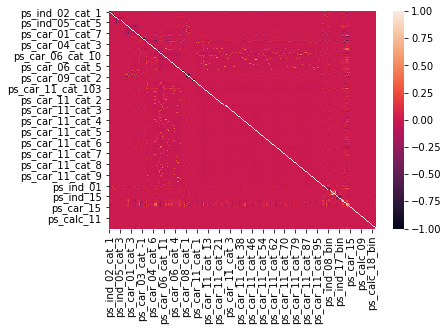

In [38]:
ax = sns.heatmap(corr)

Most of the features do not correlate with each other, we will see which ones do

In [39]:
corr_vals = abs(corr).unstack()
corr_vals[corr_vals < 1].sort_values(ascending = False)

ps_car_03_cat_0   ps_car_03_cat_1     9.999896e-01
ps_car_03_cat_1   ps_car_03_cat_0     9.999896e-01
ps_car_10_cat_1   ps_car_10_cat_0     9.796396e-01
ps_car_10_cat_0   ps_car_10_cat_1     9.796396e-01
ps_ind_12_bin     ps_ind_14           8.935260e-01
                                          ...     
ps_car_01_cat_7   ps_calc_03          7.181217e-07
ps_car_11_cat_52  ps_car_03_cat_1     5.533737e-07
ps_car_03_cat_1   ps_car_11_cat_52    5.533737e-07
ps_car_11_cat_52  ps_car_03_cat_0     1.744128e-07
ps_car_03_cat_0   ps_car_11_cat_52    1.744128e-07
Length: 48170, dtype: float64

In [40]:
corr_vals[corr_vals < 0.8].count()/corr_vals[corr_vals < 1].count()

0.9997924019099025

We will remove features that are deeply correlated:

In [41]:
corr_vals[(corr_vals > 0.8) & (corr_vals < 1)].index

MultiIndex([('ps_ind_02_cat_1', 'ps_ind_02_cat_2'),
            ('ps_ind_02_cat_2', 'ps_ind_02_cat_1'),
            ('ps_car_03_cat_0', 'ps_car_03_cat_1'),
            ('ps_car_03_cat_1', 'ps_car_03_cat_0'),
            ('ps_car_09_cat_0', 'ps_car_09_cat_2'),
            ('ps_car_09_cat_2', 'ps_car_09_cat_0'),
            ('ps_car_10_cat_0', 'ps_car_10_cat_1'),
            ('ps_car_10_cat_1', 'ps_car_10_cat_0'),
            (  'ps_ind_12_bin',       'ps_ind_14'),
            (      'ps_ind_14',   'ps_ind_12_bin')],
           )

In [42]:
data_not_na.drop(labels = ['ps_ind_02_cat_2', 
                           'ps_car_03_cat_1', 
                           'ps_car_09_cat_2',
                           'ps_car_10_cat_1',
                           'ps_ind_14'
                           ], axis = 1, inplace= True)

We will now analyze the relationships between features and target

In [44]:
feat_target_corr = corr['target'].abs().sort_values(ascending = False)
feat_target_corr.drop(['ps_ind_02_cat_2', 
                           'ps_car_03_cat_1', 
                           'ps_car_09_cat_2',
                           'ps_car_10_cat_1',
                           'ps_ind_14'], inplace = True)

In [45]:
# we will also remove features with less than 0.5% of correlation with the target

feat_target_corr[feat_target_corr < 0.005].index

Index(['ps_car_11_cat_20', 'ps_ind_10_bin', 'ps_car_11_cat_81', 'ps_car_11',
       'ps_calc_20_bin', 'ps_calc_13', 'ps_car_11_cat_40', 'ps_calc_03',
       'ps_calc_04', 'ps_car_11_cat_23', 'ps_car_05_cat_0', 'ps_car_05_cat_1',
       'ps_car_06_cat_6', 'ps_calc_16_bin', 'ps_car_11_cat_27',
       'ps_car_11_cat_1', 'ps_car_11_cat_25', 'ps_calc_10', 'ps_car_11_cat_78',
       'ps_car_11_cat_36', 'ps_calc_11', 'ps_car_11_cat_59', 'ps_ind_13_bin',
       'ps_calc_18_bin', 'ps_calc_02', 'ps_car_11_cat_86', 'ps_car_10_cat_2',
       'ps_car_11_cat_22', 'ps_car_01_cat_2', 'ps_calc_17_bin',
       'ps_car_03_cat_-1', 'ps_car_11_cat_101', 'ps_car_11_cat_76',
       'ps_car_11_cat_45', 'ps_car_11_cat_15', 'ps_car_11_cat_102',
       'ps_car_11_cat_70', 'ps_car_04_cat_7', 'ps_calc_15_bin',
       'ps_car_11_cat_2', 'ps_car_11_cat_8', 'ps_car_11_cat_80', 'ps_calc_05',
       'ps_car_11_cat_46', 'ps_car_11_cat_91', 'ps_car_01_cat_10',
       'ps_car_11_cat_34', 'ps_calc_08', 'ps_car_11_cat_98', 

In [46]:
data_not_na.drop(feat_target_corr[feat_target_corr < 0.005].index, axis = 1, inplace=True)

## 7. Feature and Target analysis

Analyzing the distribution of categorical features

In [47]:
data_not_na.columns

Index(['ps_ind_02_cat_1', 'ps_ind_02_cat_3', 'ps_ind_02_cat_4',
       'ps_ind_04_cat_0', 'ps_ind_04_cat_1', 'ps_ind_05_cat_0',
       'ps_ind_05_cat_1', 'ps_ind_05_cat_2', 'ps_ind_05_cat_3',
       'ps_ind_05_cat_4',
       ...
       'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01',
       'ps_calc_06', 'ps_calc_07', 'ps_calc_12', 'ps_calc_14', 'target'],
      dtype='object', length=155)

In [48]:
data_cat = data_not_na.filter(regex= 'cat|bin')
data_cat.columns

Index(['ps_ind_02_cat_1', 'ps_ind_02_cat_3', 'ps_ind_02_cat_4',
       'ps_ind_04_cat_0', 'ps_ind_04_cat_1', 'ps_ind_05_cat_0',
       'ps_ind_05_cat_1', 'ps_ind_05_cat_2', 'ps_ind_05_cat_3',
       'ps_ind_05_cat_4',
       ...
       'ps_car_11_cat_99', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_16_bin',
       'ps_ind_17_bin', 'ps_ind_18_bin'],
      dtype='object', length=139)

In [49]:
cat_target = pd.concat([data_cat, data_not_na['target']], axis=1)

In [50]:
cat_target.drop('target', axis=1).describe()

,ps_ind_02_cat_1,ps_ind_02_cat_3,ps_ind_02_cat_4,ps_ind_04_cat_0,ps_ind_04_cat_1,ps_ind_05_cat_0,ps_ind_05_cat_1,ps_ind_05_cat_2,ps_ind_05_cat_3,ps_ind_05_cat_4,ps_ind_05_cat_5,ps_ind_05_cat_6,ps_car_01_cat_0,ps_car_01_cat_1,ps_car_01_cat_11,ps_car_01_cat_4,ps_car_01_cat_5,ps_car_01_cat_6,ps_car_01_cat_7,ps_car_01_cat_8,ps_car_01_cat_9,ps_car_02_cat_0,ps_car_02_cat_1,ps_car_03_cat_0,ps_car_04_cat_0,ps_car_04_cat_1,ps_car_04_cat_2,ps_car_04_cat_4,ps_car_04_cat_5,ps_car_04_cat_6,ps_car_04_cat_8,ps_car_04_cat_9,ps_car_06_cat_0,ps_car_06_cat_1,ps_car_06_cat_10,ps_car_06_cat_11,ps_car_06_cat_12,ps_car_06_cat_13,ps_car_06_cat_14,ps_car_06_cat_15,...,ps_car_11_cat_6,ps_car_11_cat_60,ps_car_11_cat_61,ps_car_11_cat_63,ps_car_11_cat_64,ps_car_11_cat_65,ps_car_11_cat_66,ps_car_11_cat_67,ps_car_11_cat_68,ps_car_11_cat_69,ps_car_11_cat_7,ps_car_11_cat_71,ps_car_11_cat_72,ps_car_11_cat_74,ps_car_11_cat_75,ps_car_11_cat_79,ps_car_11_cat_82,ps_car_11_cat_83,ps_car_11_cat_84,ps_car_11_cat_85,ps_car_11_cat_87,ps_car_11_cat_89,ps_car_11_cat_9,ps_car_11_cat_90,ps_car_11_cat_92,ps_car_11_cat_93,ps_car_11_cat_94,ps_car_11_cat_95,ps_car_11_cat_96,ps_car_11_cat_97,ps_car_11_cat_99,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin
count,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,...,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000,603310.000000
mean,0.718188,0.048753,0.021374,0.569417,0.430583,0.871973,0.015790,0.010311,0.015345,0.037356,0.003012,0.046213,0.011313,0.002645,0.372788,0.045890,0.031191,0.097597,0.270120,0.028189,0.040628,0.199846,0.800154,0.392891,0.800434,0.063468,0.046416,0.000254,0.001162,0.003207,0.042134,0.041564,0.179737,0.190802,0.062397,0.205423,0.005032,0.013451,0.096864,0.043603,...,0.004482,0.012634,0.006023,0.002514,0.034228,0.017215,0.004580,0.009965,0.013559,0.003966,0.008029,0.005162,0.006284,0.007409,0.003864,0.003927,0.015395,0.017492,0.007747,0.009428,0.027641,0.009451,0.003305,0.009721,0.011457,0.006809,0.006761,0.005309,0.002882,0.002899,0.016647,0.353228,0.293023,0.177284,0.176465,0.002007,0.011710,0.628703,0.150705,0.157765
std,0.449883,0.215351,0.144627,0.495158,0.495158,0.334120,0.124661,0.101020,0.122922,0.189632,0.054796,0.209947,0.105757,0.051365,0.483547,0.209247,0.173834,0.296769,0.444022,0.165514,0.197426,0.399885,0.399885,0.488393,0.399674,0.243803,0.210384,0.015923,0.034067,0.056542,0.200895,0.199591,0.383968,0.392934,0.241876,0.404011,0.070760,0.115195,0.295773,0.204210,...,0.066797,0.111687,0.077377,0.050081,0.181814,0.130072,0.067519,0.099326,0.115649,0.062855,0.089245,0.071658,0.079020,0.085757,0.062038,0.062540,0.123118,0.131095,0.087677,0.096639,0.163942,0.096757,0.057395,0.098117,0.106422,0.082236,0.081947,0.072670,0.053611,0.053764,0.127943,0.477973,0.455149,0.381909,0.381215,0.044758,0.107579,0.483152,0.357762,0.364521
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000

We will analzye features that 95% of the registries or more are towards 0 or 1

In [51]:
cattarget_mean = cat_target.drop('target', axis=1).mean()
cattarget_mean_extremes = cattarget_mean[(cattarget_mean < 0.05)|(cattarget_mean > 0.95)]
cattarget_mean_extremes = pd.concat([data_not_na[cattarget_mean_extremes.index], data_not_na['target']], axis=1)

In [52]:
cattarget_mean_extremes

,ps_ind_02_cat_3,ps_ind_02_cat_4,ps_ind_05_cat_1,ps_ind_05_cat_2,ps_ind_05_cat_3,ps_ind_05_cat_4,ps_ind_05_cat_5,ps_ind_05_cat_6,ps_car_01_cat_0,ps_car_01_cat_1,ps_car_01_cat_4,ps_car_01_cat_5,ps_car_01_cat_8,ps_car_01_cat_9,ps_car_04_cat_2,ps_car_04_cat_4,ps_car_04_cat_5,ps_car_04_cat_6,ps_car_04_cat_8,ps_car_04_cat_9,ps_car_06_cat_12,ps_car_06_cat_13,ps_car_06_cat_15,ps_car_06_cat_16,ps_car_06_cat_17,ps_car_06_cat_2,ps_car_06_cat_5,ps_car_06_cat_7,ps_car_06_cat_8,ps_car_06_cat_9,ps_car_09_cat_4,ps_car_10_cat_0,ps_car_11_cat_10,ps_car_11_cat_100,ps_car_11_cat_103,ps_car_11_cat_11,ps_car_11_cat_12,ps_car_11_cat_13,ps_car_11_cat_14,ps_car_11_cat_16,...,ps_car_11_cat_53,ps_car_11_cat_54,ps_car_11_cat_55,ps_car_11_cat_56,ps_car_11_cat_57,ps_car_11_cat_58,ps_car_11_cat_6,ps_car_11_cat_60,ps_car_11_cat_61,ps_car_11_cat_63,ps_car_11_cat_64,ps_car_11_cat_65,ps_car_11_cat_66,ps_car_11_cat_67,ps_car_11_cat_68,ps_car_11_cat_69,ps_car_11_cat_7,ps_car_11_cat_71,ps_car_11_cat_72,ps_car_11_cat_74,ps_car_11_cat_75,ps_car_11_cat_79,ps_car_11_cat_82,ps_car_11_cat_83,ps_car_11_cat_84,ps_car_11_cat_85,ps_car_11_cat_87,ps_car_11_cat_89,ps_car_11_cat_9,ps_car_11_cat_90,ps_car_11_cat_92,ps_car_11_cat_93,ps_car_11_cat_94,ps_car_11_cat_95,ps_car_11_cat_96,ps_car_11_cat_97,ps_car_11_cat_99,ps_ind_11_bin,ps_ind_12_bin,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
603306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
603307,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

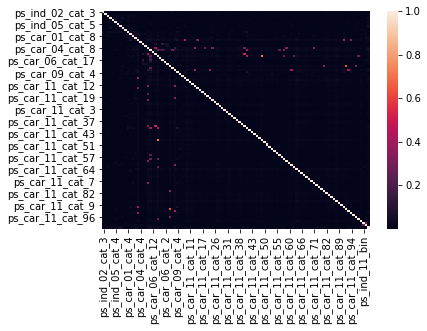

In [53]:
sns.heatmap(cattarget_mean_extremes.corr().abs())

They`re correlation with the target is small, we can remove these columns

In [54]:
data_not_na.drop(cattarget_mean_extremes.drop('target', axis=1).columns, axis=1, inplace = True)

## 8. Data Modelling

In [55]:
data_not_na.target.shape

(603310,)

In [56]:
y_res.shape

(603310,)

## 9. Machine Learning application

Dividing our model into train and test sets

We can see below the difference between the unbalanced example for the balanced one in the model.

##### before balancing and feature engineering example:

In [58]:
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(data_not_na_unbalanced.drop(["target", "id"], axis=1), 
                                                    data_not_na_unbalanced.target, 
                                                    test_size=0.33, 
                                                    random_state=42)

Applying a simple regression modelling to our data

In [59]:
#lr = LogisticRegression().fit(X_train, y_train)
dtc_u = DecisionTreeClassifier().fit(X_train_u, y_train_u)

######After balancing and feature engineering:

In [60]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(data_not_na.drop('target', axis=1), 
                                                    data_not_na.target, 
                                                    test_size=0.33, 
                                                    random_state=42)

In [61]:
dtc_b = DecisionTreeClassifier().fit(X_train_b, y_train_b)

## 10. Model metric assesment

##### Unbalanced example:

In [70]:
predictions_u = pd.DataFrame(
    data = {
        "real_test": y_test_u,
        "predicted_test": dtc_u.predict(X_test_u)
    }
)

In [71]:
print(confusion_matrix(predictions_u.real_test, predictions_u.predicted_test))
print(classification_report(predictions_u.real_test, predictions_u.predicted_test))

[[95084  4378]
 [ 3623   231]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     99462
           1       0.05      0.06      0.05      3854

    accuracy                           0.92    103316
   macro avg       0.51      0.51      0.51    103316
weighted avg       0.93      0.92      0.93    103316



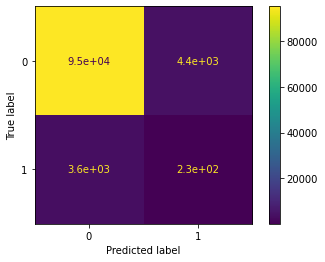

In [72]:
plot_confusion_matrix(dtc_u, X_test_u, y_test_u)

##### Balanced:

In [73]:
predictions_b = pd.DataFrame(
    data = {
        "real_test": y_test_b,
        "predicted_test": dtc_b.predict(X_test_b)
    }
)

In [74]:
print(confusion_matrix(predictions_b.real_test, predictions_b.predicted_test))
print(classification_report(predictions_b.real_test, predictions_b.predicted_test))

[[94030  5452]
 [    0 99611]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     99482
           1       0.95      1.00      0.97     99611

    accuracy                           0.97    199093
   macro avg       0.97      0.97      0.97    199093
weighted avg       0.97      0.97      0.97    199093



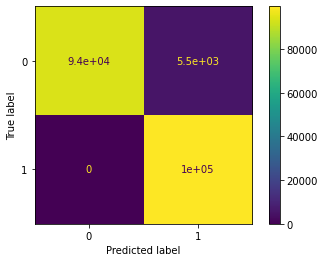

In [75]:
plot_confusion_matrix(dtc_b, X_test_b, y_test_b)

In [ ]:
predictions_b
output_filename = "output_porto_seguro.csv"
predictions_b.to_csv(output_filename)
files.download(output_filename) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 11. Submitting model to a production environment

In [ ]:
test_data = pd.read_csv("test.csv")

In [ ]:
# Kaggle submittion

predictions = pd.DataFrame()
predictions["target"] = dtc_b.predict(test_data.drop("id", axis=1))
predictions["id"] = test_data["id"]
predictions.set_index("id", inplace = True)
#predictions.drop("id", axis=1, inplace = True)
output_filename = "output_porto_seguro_kaggle_balanced_test.csv"
predictions.to_csv(output_filename)
files.download(output_filename) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>